# This practice will cover learning points in class2
### 1 - Fit MLR model in python with sklearn and statesmodel packages
### 2 - Model Selection
### 3 - Weighted regression
### 4 - Regularization, L1 and L2

Import required Python packages.

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

%matplotlib inline

no display found. Using non-interactive Agg backend


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [11]:
DATA = Path('.').resolve().parents[1] / 'Practice/mlr'

HOUSE_CSV = DATA / 'house_sales.csv'

In [14]:
# print(DATA)
# print(HOUSE_CSV)

#### Data read and train-test split

In [15]:
houseall = pd.read_csv(HOUSE_CSV, sep='\t')

house, house_test = train_test_split(houseall, test_size=0.2)

print(house.head())
print(house.shape)

print(house_test.head())
print(house_test.shape)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
5300    2012-07-03     146000  1788700090  Single Family  2012-07-01   325300   
12681   2006-10-11     307950  3782100070  Single Family  2006-10-01   418300   
13033   2008-07-24     790000  3856904580  Single Family  2008-07-01   400300   
14012   2011-03-02     484000  4100000070  Single Family  2011-03-01   321600   
6692    2007-09-12     445000  2202500225  Single Family  2007-09-01   433500   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
5300   0.747472      195325.0               1     8424  ...       1.00   
12681  0.961167      320392.0               1     8100  ...       2.00   
13033  0.919807      858876.0               1     4080  ...       1.75   
14012  0.738971      654965.0               1    11804  ...       2.75   
6692   0.996094      446745.0               1     8742  ...       1.00   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

We can use the `LinearRegression` model from _scikit-learn_.

## 1 - Multiple Linear Regression (SKlearn)

In [16]:
print(house.head())
print(house.columns)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
5300    2012-07-03     146000  1788700090  Single Family  2012-07-01   325300   
12681   2006-10-11     307950  3782100070  Single Family  2006-10-01   418300   
13033   2008-07-24     790000  3856904580  Single Family  2008-07-01   400300   
14012   2011-03-02     484000  4100000070  Single Family  2011-03-01   321600   
6692    2007-09-12     445000  2202500225  Single Family  2007-09-01   433500   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
5300   0.747472      195325.0               1     8424  ...       1.00   
12681  0.961167      320392.0               1     8100  ...       2.00   
13033  0.919807      858876.0               1     4080  ...       1.75   
14012  0.738971      654965.0               1    11804  ...       2.75   
6692   0.996094      446745.0               1     8742  ...       1.00   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

In [17]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

print(house[subset].head())

       AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
5300       195325.0            820     8424       1.00         3          6
12681      320392.0            960     8100       2.00         3          7
13033      858876.0           2050     4080       1.75         3          8
14012      654965.0           1920    11804       2.75         5          8
6692       446745.0           1210     8742       1.00         3          7


In [18]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -525518.269
Coefficients:
 SqFtTotLiving: 227.14262463116722
 SqFtLot: -0.04774690506471718
 Bathrooms: -19024.409514713094
 Bedrooms: -45807.658413188576
 BldgGrade: 106099.73646141501


### Assessing the Model with performance KPIs
_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score` and `RMSE`.

In [21]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

fitted_test = house_lm.predict(house_test[predictors])
RMSE_test = np.sqrt(mean_squared_error(house_test[outcome], fitted_test))
r2_test = r2_score(house_test[outcome], fitted_test)
print(f'RMSE_test: {RMSE_test:.0f}')
print(f'r2_test: {r2_test:.4f}')

RMSE: 261734
r2: 0.5424
RMSE_test: 259179
r2_test: 0.5324


## 1 - Multiple Linear Regression (statsmodels)

While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [23]:
mlr_sm = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = mlr_sm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     4302.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:00:50   Log-Likelihood:            -2.5216e+05
No. Observations:               18149   AIC:                         5.043e+05
Df Residuals:                   18143   BIC:                         5.044e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   227.1426      4.350     52.222

### Correlations between predictors

Correlation Matrix 
                SqFtTotLiving   SqFtLot  Bathrooms  Bedrooms  BldgGrade
SqFtTotLiving       1.000000  0.194438   0.764795  0.596046   0.772365
SqFtLot             0.194438  1.000000   0.107111  0.065361   0.143378
Bathrooms           0.764795  0.107111   1.000000  0.537875   0.657983
Bedrooms            0.596046  0.065361   0.537875  1.000000   0.365975
BldgGrade           0.772365  0.143378   0.657983  0.365975   1.000000


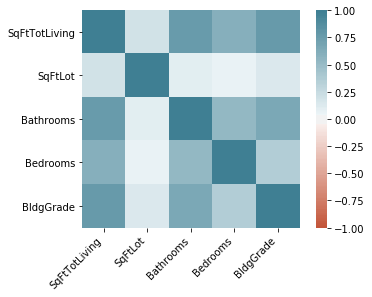

In [22]:
corr = house[predictors].corr()
print("Correlation Matrix \n {}".format(corr))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## 2 - Model Selection and Stepwise Regression

In [24]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

print("\nPredictors after nominal varibale(s) treatment: {} \n\n".format(X.shape))

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
5300             820     8424       1.00         3          6  Single Family   
12681            960     8100       2.00         3          7  Single Family   
13033           2050     4080       1.75         3          8  Single Family   
14012           1920    11804       2.75         5          8  Single Family   
6692            1210     8742       1.00         3          7  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
5300                1                0     1959            0            False  
12681               1                0     1955            0            False  
13033               1                0     1991            0            False  
14012               1              270     1960            0            False  
6692                1                0     1954            0            False  

 PropertyType List 
Single Family    1

We can use the `stepwise_selection` method from the _dmba_ package.

In [25]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=518519.13, constant
Step: score=506450.10, add SqFtTotLiving
Step: score=504672.60, add BldgGrade
Step: score=502600.59, add YrBuilt
Step: score=502257.77, add Bedrooms
Step: score=502112.85, add Bathrooms
Step: score=502053.37, add PropertyType_Townhouse
Step: score=502051.76, add SqFtFinBasement
Step: score=502051.76, unchanged None

Intercept: 6178772.254
Coefficients:
 SqFtTotLiving: 196.48595552469854
 BldgGrade: 138804.31057533738
 YrBuilt: -3558.546935270238
 Bedrooms: -50790.30196263888
 Bathrooms: 41290.917740694735
 PropertyType_Townhouse: 59881.67052978481
 SqFtFinBasement: 9.745907589097285


## 3 - Weighted regression
For the house data recent sale price is more relavent for future prediction, old sale data is less reliable, therefore, we like to emphasis the recent sale data by apply more weight. We will use year the house sale to 2005 as weight.

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [26]:
print("\nDocumentDate List \n{}".format(house['DocumentDate'].value_counts(dropna=False)))


DocumentDate List 
2006-07-26    48
2006-06-01    46
2006-06-08    46
2006-06-19    44
2006-08-24    43
              ..
2011-07-16     1
2007-06-16     1
2014-03-13     1
2014-03-20     1
2006-11-19     1
Name: DocumentDate, Length: 2469, dtype: int64


In [27]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]  #list comprehension
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))  # apply()
house['Weight'] = house.Year - 2005

/Users/yibin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yibin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yibin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [28]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

,predictor,house_lm,house_wt
0,SqFtTotLiving,227.142625,244.009023
1,SqFtLot,-0.047747,-0.275870
2,Bathrooms,-19024.409515,-27194.594125
3,Bedrooms,-45807.658413,-52686.235249
4,BldgGrade,106099.736461,116905.612754
5,intercept,-525518.269179,-594454.152302


       abs_residual_lm  abs_residual_wt  Year
5300      54837.502895     75835.307404  2012
12681     61013.738503     76940.643645  2006
13033    240864.496256    224641.549378  2008
14012    177490.560894    187149.608272  2011
6692     111587.326343    115273.902482  2007


Year   Abs_residual_lm    Abs_residual_wt
2006 140301.41358480236 146818.89084935014
2007 149690.02198768506 155264.09627123203
2008 142848.33468595732 147401.07726008113
2009 146480.20215901546 151323.71380213578
2010 158546.4550668623 161823.9627388648
2011 174105.2376369793 177296.55379437498
2012 164171.50685921582 166094.64278194302
2013 209999.093540516 212302.2104875012
2014 193670.5095636271 195773.54060688117
2015 172639.22850036158 169717.27428566746


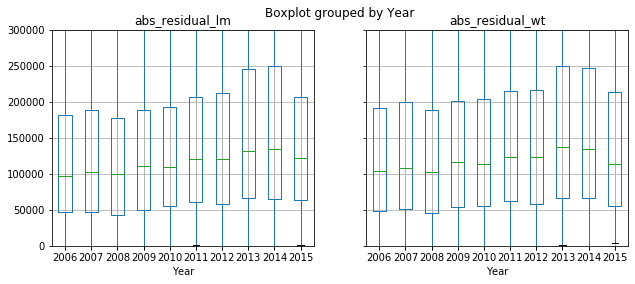

In [29]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

print("\n\nYear   Abs_residual_lm    Abs_residual_wt")
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

Seems only help 2015 prediction reduce the residuale.If we have a recent holdout sample we can test the weight could help for furture prediction or not

# 4 - Regularization

In [30]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

outcome = 'AdjSalePrice'

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X_train = pd.get_dummies(house[predictors], drop_first=True)
X_train['NewConstruction'] = [1 if nc else 0 for nc in X_train['NewConstruction']]
y_train = house[outcome]

X_test = pd.get_dummies(house_test[predictors], drop_first=True)
X_test['NewConstruction'] = [1 if nc else 0 for nc in X_test['NewConstruction']]
y_test = house_test[outcome]

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
5300             820     8424       1.00         3          6  Single Family   
12681            960     8100       2.00         3          7  Single Family   
13033           2050     4080       1.75         3          8  Single Family   
14012           1920    11804       2.75         5          8  Single Family   
6692            1210     8742       1.00         3          7  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
5300                1                0     1959            0            False  
12681               1                0     1955            0            False  
13033               1                0     1991            0            False  
14012               1              270     1960            0            False  
6692                1                0     1954            0            False  

 PropertyType List 
Single Family    1

### Regular Multiple Regression

In [31]:
house_lm = LinearRegression()
house_lm.fit(X_train, y_train)

mlr_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((house_lm.intercept_, house_lm.coef_), 
                                axis=None), 3))
)

mlr_coefs

{'Intercept': 6097167.345,
 'SqFtTotLiving': 195.515,
 'SqFtLot': 0.081,
 'Bathrooms': 41510.984,
 'Bedrooms': -50499.827,
 'BldgGrade': 138849.457,
 'NbrLivingUnits': 24622.864,
 'SqFtFinBasement': 9.717,
 'YrBuilt': -3555.798,
 'YrRenovated': 0.796,
 'NewConstruction': -2278.04,
 'PropertyType_Single Family': 51017.157}

In [32]:
fitted_test = house_lm.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, fitted_test))
r2 = r2_score(y_test, fitted_test)
print(f'regular mlr MSE: {MSE_test:.0f}')
print(f'r2_test: {r2:.4f}')

regular mlr MSE: 244299
r2_test: 0.5845


### L2 - Ridge regression (Parameter shrinkage)

In [33]:
ridge_cv = RidgeCV(normalize=True, alphas=np.logspace(-10, 1, 400))
ridge_model = ridge_cv.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)
ridge_mae = np.mean(np.abs(y_test - ridge_prediction))
ridge_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((ridge_model.intercept_, ridge_model.coef_), 
                                axis=None), 3))
)

print('Ridge Regression MAE: {}'.format(np.round(ridge_mae, 3)))
print('Ridge Regression coefficients:')
ridge_coefs

Ridge Regression MAE: 135479.682
Ridge Regression coefficients:


{'Intercept': 5983425.905,
 'SqFtTotLiving': 191.452,
 'SqFtLot': 0.091,
 'Bathrooms': 42746.236,
 'Bedrooms': -49179.085,
 'BldgGrade': 138505.546,
 'NbrLivingUnits': 16505.754,
 'SqFtFinBasement': 12.46,
 'YrBuilt': -3484.417,
 'YrRenovated': 1.927,
 'NewConstruction': -2369.944,
 'PropertyType_Single Family': 35398.442}

### L1 - Lasso regression (Parameter sparsity)

In [34]:
lasso_cv = LassoCV(normalize=True, alphas=np.logspace(-10, 1, 400))
lasso_model = lasso_cv.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
lasso_mae = np.mean(np.abs(y_test - lasso_prediction))
lasso_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((lasso_model.intercept_, lasso_model.coef_), axis=None), 3))
)

print('LASSO MAE: {}'.format(np.round(lasso_mae, 3)))
print('LASSO coefficients:')
lasso_coefs

LASSO MAE: 135522.604
LASSO coefficients:


{'Intercept': 6055517.602,
 'SqFtTotLiving': 194.216,
 'SqFtLot': 0.064,
 'Bathrooms': 39776.616,
 'Bedrooms': -48619.885,
 'BldgGrade': 138660.216,
 'NbrLivingUnits': -0.0,
 'SqFtFinBasement': 9.912,
 'YrBuilt': -3495.387,
 'YrRenovated': 0.533,
 'NewConstruction': -0.0,
 'PropertyType_Single Family': 0.0}

# Home Work

1. Compare the three model fits and draw conclusion 
from the comparision of the three model fits regarding there coefficent difference

2. Show the three model performance on both train and test